In [160]:
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import hashlib
import math
import cv2
import scipy

In [161]:
class Arnold:

    def __init__(self, a:int, b:int, rounds:int):
        # Parameters
        self.__a = a
        self.__b = b
        self.__rounds = rounds

    def mapping(self, s:np.shape):
        x, y = np.meshgrid(range(s[0]), range(s[0]), indexing="ij")
        xmap = (self.__a*self.__b*x + x + self.__a*y) % s[0]
        ymap = (self.__b*x + y) % s[0]
        return xmap, ymap

    def inverseMapping(self, s:np.shape):
        x, y = np.meshgrid(range(s[0]), range(s[0]), indexing="ij")
        xmap = (x - self.__a*y) % s[0]
        ymap = (-self.__b*x + self.__a*self.__b*y + y) % s[0]
        return xmap, ymap

    def applyTransformTo(self, image:np.ndarray):
        xm, ym = self.mapping(image.shape)
        img = image
        for r in range(self.__rounds):
            img = img[xm, ym]
        return img

    def applyInverseTransformTo(self, image:np.ndarray):
        xm, ym = self.inverseMapping(image.shape)
        img = image
        for r in range(self.__rounds):
            img = img[xm, ym]
        return img

In [162]:
# Chirikov standard map
def generateChirikovMap(xo, yo, iter, delta, to):
    x = []
    y = []
    for i in range(iter+to):
        x1 = (xo+yo)%(2*math.pi)
        y1 = (xo+delta*math.sin(xo+yo))%(2*math.pi)
        xo = x1
        yo = y1
        if i>=to:
            x.append(x1)
            y.append(y1)
    return x,y


In [163]:
def padding(image):
    M,N = image.shape
    if (M<N):
        pad = np.zeros((N,N))
        pad[0:M,:] = image
    else:
        pad = np.zeros((M,M))
        pad[:,0:N] = image
    return pad

In [164]:
def unpadding(M, N, image):
    return image[0:M,0:N]

In [165]:
password = 'a'
hash = hashlib.sha512(password.encode())
hash_str = hash.hexdigest()
k = []
prev = 0
for i in range(2,129,2):
    kth = hash_str[prev:i]
    prev = i
    k.append(int(kth, 16))
a1 = reduce(lambda x, y: x ^ y, k[:16])
a2 = reduce(lambda x, y: x ^ y, k[16:32])
a3 = reduce(lambda x, y: x ^ y, k[32:48])
a4 = reduce(lambda x, y: x ^ y, k[48:64])
t1 = 1
t2 = 2
t3 = 3
t4 = 4
# Four parameters
h1 = t1 + (a1+a2)/256
h2 = t2 * (a3+a4)/256
h3 = t3 + (a1+a2)/256
h4 = t4 * 256 * sum(k[16:32])/max(k[16:32])
# parameters u1, u2, x1, x2 are used as initial values of the 4-D hyperchaotic system
xo = (math.floor((h1 + h2 + h3) * 1e5) % 512)/512
yo = (math.floor((h2 + h3 + h4) * 1e5) % 512)/512
xo_ = (math.floor((h1 + h2 + h3 + h4) * 1e5) % 512)/512
yo_ = (math.floor((h1 + h4) * 1e5) % 512)/512

In [166]:
image = cv2.imread('./img.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1536, 2048, 3)

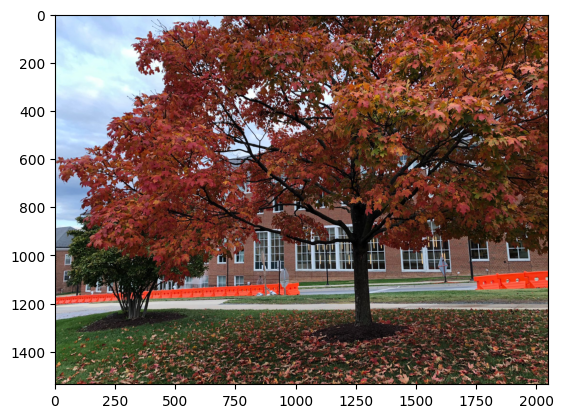

In [167]:
imgplot = plt.imshow(image)

In [113]:
I1 = image[:,:,0]
I2 = image[:,:,1]
I3 = image[:,:,2]

In [114]:
print(I1.shape)
print(I2.shape)
print(I3.shape)

(1536, 2048)
(1536, 2048)
(1536, 2048)


In [169]:
M = I1.shape[0]
N = I1.shape[1]

In [170]:
# Generate chaotic chirikov map for vertical shift
x3m,y1 = generateChirikovMap(xo, yo, 3*M, 0.1, 1000)
# plot1 = plt.plot(x,y1)
x3m = np.array(x3m)
print(len(x3m))
x1,yn = generateChirikovMap(xo, yo, N, 0.1, 1000)
# plot2 = plt.plot(x1,y)
yn = np.array(yn)
print(len(yn))

4608
2048


In [171]:
# Generated chaotic sequence for encryption
Xv = np.floor(x3m*1e14)%N
Yv = np.floor(yn*1e14)%(3*M)

In [172]:
# Combining the three indexed images
Fv = np.concatenate((I1, I2, I3))
actual_concat = np.copy(Fv)
Fv.shape

(4608, 2048)

In [173]:
Fv

array([[194, 194, 194, ..., 153, 151, 151],
       [195, 195, 195, ..., 150, 148, 147],
       [195, 195, 195, ..., 148, 147, 148],
       ...,
       [ 54,  55,  51, ...,  76,  80,  39],
       [ 44,  47,  48, ...,  47,  78,  95],
       [ 49,  48,  46, ...,   9,   7,  14]], dtype=uint8)

In [174]:
# Performing right shift in dimension N
for i in range(len(Xv)):
    row = Fv[i,:]
    Fv[i,:] = np.roll(row, int(Xv[i]))

In [175]:
Fv

array([[ 35,  34,  34, ...,  37,  32,  23],
       [ 20,  29,  34, ...,  63, 161,  88],
       [173, 173, 173, ..., 173, 173, 173],
       ...,
       [109, 114,  78, ...,  36, 117, 117],
       [  1,   3,  39, ...,  24,   6,   5],
       [ 51,  26,   3, ...,   7,   0,  33]], dtype=uint8)

In [120]:
Fv.shape

(4608, 2048)

In [121]:
# Performing bottom shift in dimension 3M
for j in range(len(Yv)):
    column = Fv[:,j]
    Fv[:,j] = np.roll(column, int(Yv[j]))
print(Fv.shape)

(4608, 2048)


In [122]:
# Decomposing the scrambled image into three channels
F1 = Fv[0:M, :]
F2 = Fv[M:2*M, :]
F3 = Fv[2*M:3*M, :]

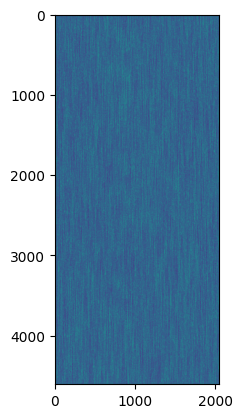

In [123]:
plt.imshow(Fv)

In [176]:
# Horizontal concatenation of the three channels
Fh = np.concatenate((F1, F2, F3), axis=1)

In [177]:
Fh

array([[ 19, 163, 213, ...,  35, 136, 128],
       [ 79,  79,  21, ..., 143,  58, 209],
       [ 64,  61, 139, ..., 117, 104,  68],
       ...,
       [ 68,  53,  53, ..., 252,  23,  39],
       [ 89,  82, 219, ..., 107,   4,  83],
       [ 99,   8, 215, ...,  28,   8,  67]], dtype=uint8)

In [178]:
F_checkh = np.copy(Fh)

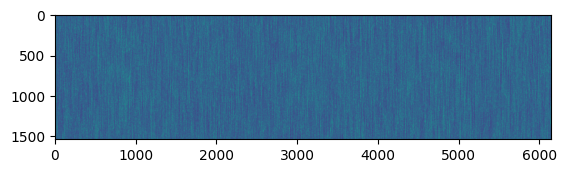

In [179]:
# After performing right shift the encrypted image is 
Fh_plot = plt.imshow(Fh)

In [180]:
# Generate chaotic chirikov map for vertical shift
xh,_ = generateChirikovMap(xo_, yo_, M, 0.1, 1000)
xh = np.array(xh)
print(len(xh))
_,yh = generateChirikovMap(xo_, yo_, 3*N, 0.1, 1000)
yh = np.array(yh)
print(len(yh))

Xh = np.floor(xh*1e14)%(3*N)
Yh = np.floor(yh*1e14)%M

1536
6144


In [181]:
# Performing left shift in dimension N
for i in range(len(Xh)):
    row = Fh[i,:]
    Fh[i,:] = np.roll(row, int(Xh[i]))

# Performing bottom shift in dimension M
for j in range(len(Yh)):
    column = Fh[:,j]
    Fh[:,j] = np.roll(column, int(Yh[j]))

print(Fh.shape)

(1536, 6144)


In [182]:
C1 = Fh[:, 0:N]
C2 = Fh[:, N:2*N]
C3 = Fh[:, 2*N:3*N]

In [183]:
# Encrypted image
E = np.zeros((M, N, 3), dtype=np.uint8)
E[:,:,0] = C1
E[:,:,1] = C2
E[:,:,2] = C3

In [184]:
C1_dct = scipy.fftpack.dct(C1, axis=0, norm='ortho', type=2)
C2_dct = scipy.fftpack.dct(C2, axis=0, norm='ortho', type=2)
C3_dct = scipy.fftpack.dct(C3, axis=0, norm='ortho', type=2)

In [185]:
dct_im = np.zeros((C1_dct.shape[0],C1_dct.shape[1],3))
dct_im[:,:,0] = C1_dct
dct_im[:,:,1] = C2_dct
dct_im[:,:,2] = C3_dct

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


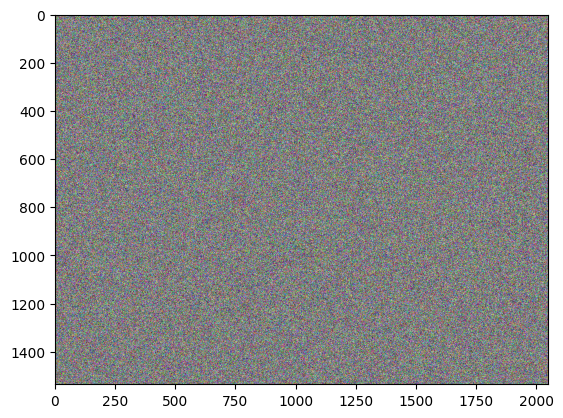

In [186]:
plt.imshow(dct_im)

In [187]:
# padding
C1_pad = padding(C1_dct)
C2_pad = padding(C2_dct)
C3_pad = padding(C3_dct)

In [188]:
arnold = Arnold(1, 2, 20)

In [189]:
C1_AT = arnold.applyTransformTo(C1_pad)
C2_AT = arnold.applyTransformTo(C2_pad)
C3_AT = arnold.applyTransformTo(C3_pad)

In [190]:
C1_AT.shape

(2048, 2048)

In [191]:
encrypted_img = np.zeros((C1_AT.shape[0], C1_AT.shape[1], 3))
encrypted_img[:,:,0] = C1_AT
encrypted_img[:,:,1] = C2_AT
encrypted_img[:,:,2] = C3_AT

In [192]:
encrypted_img

array([[[ 3.26236312e+03,  3.36189916e+03,  3.12138988e+03],
        [-2.04765920e+01, -2.51410836e+00,  6.93277239e+01],
        [ 9.22499794e+00,  9.50276095e+01,  8.35427896e+01],
        ...,
        [ 1.35119736e+02, -7.48995966e+00,  1.47454962e+01],
        [-1.37808695e+01,  1.25375928e+01, -9.16656764e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.54233238e+01,  3.06973849e+01,  4.51284415e+01],
        [ 2.13730143e+01, -9.67270238e+01, -6.54776849e+01],
        [ 8.41040835e+01,  2.60648161e+01,  2.67022604e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.49418107e+01, -6.12787821e+01, -1.34206340e+02],
        [-3.02653976e+01,  1.47949881e+01,  5.26400369e+01]],

       [[-8.36714614e+01,  1.31266126e+02,  2.21969986e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.03806571e+02, -1.36306025e+02,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


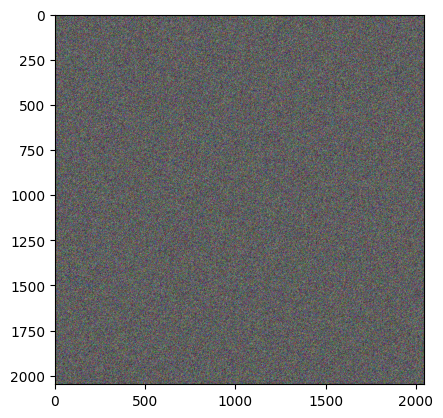

In [139]:
encrypted_img_plot = plt.imshow(encrypted_img)

# inverse AT

In [140]:
iC1_AT = encrypted_img[:,:,0]
iC2_AT = encrypted_img[:,:,1]
iC3_AT = encrypted_img[:,:,2]

In [141]:
IC1_AT = arnold.applyInverseTransformTo(iC1_AT)
IC2_AT = arnold.applyInverseTransformTo(iC2_AT)
IC3_AT = arnold.applyInverseTransformTo(iC3_AT)

In [142]:
# unpadding 
IC1_unpad = unpadding(M, N, IC1_AT)
IC2_unpad = unpadding(M, N, IC2_AT)
IC3_unpad = unpadding(M, N, IC3_AT)


# Inverse DCT

In [143]:
iC1 = scipy.fftpack.idct(IC1_unpad, axis=0, norm='ortho', type=2)
iC2 = scipy.fftpack.idct(IC2_unpad, axis=0, norm='ortho', type=2)
iC3 = scipy.fftpack.idct(IC3_unpad, axis=0, norm='ortho', type=2)

In [144]:
iC1 = iC1.round().astype(np.uint8)
iC2 = iC2.round().astype(np.uint8)
iC3 = iC3.round().astype(np.uint8)

# Inverse horizontal

In [145]:
iFh = np.concatenate([iC1,iC2,iC3], axis=1)
print(iFh.shape)

(1536, 6144)


In [146]:
print(iFh)

[[ 34 248 252 ... 131 194  91]
 [196  34  34 ... 119  66  72]
 [ 67  75 206 ...  51  37 162]
 ...
 [ 16 219  48 ...  59  75 203]
 [ 57  38  30 ...  74 181  64]
 [ 38  55  62 ... 207 185  43]]


In [147]:
# Generate chaotic chirikov map for vertical shift
ixm,y1 = generateChirikovMap(xo_, yo_, M, 0.1, 1000)
# plot1 = plt.plot(x,y1)
ixm = np.array(ixm)
print(len(ixm))
x1,iy3n = generateChirikovMap(xo_, yo_, 3*N, 0.1, 1000)
# plot2 = plt.plot(x1,y)
iy3n = np.array(iy3n)
print(len(iy3n))

iXh = np.floor(ixm*1e14)%(3*N)
iYh = np.floor(iy3n*1e14)%M

1536
6144


In [148]:
# Performing bottom shift in dimension M
for j in range(len(iYh)):
    column = iFh[:,j]
    iFh[:,j] = np.roll(column, -int(iYh[j]))

# Performing bottom shift in dimension N
for i in range(len(iXh)):
    row = iFh[i,:]
    iFh[i,:] = np.roll(row, -int(iXh[i]))

In [149]:
iFh.shape

(1536, 6144)

In [150]:
F1 = iFh[:,:N]
F2 = iFh[:,N:2*N]
F3 = iFh[:,2*N:3*N]

Fv = np.concatenate([F1,F2,F3])

In [151]:
print(Fv)

[[ 19 163 213 ...  19 255  15]
 [ 79  79  21 ...   4  83  33]
 [ 64  61 139 ...   0 255 233]
 ...
 [ 51  20  79 ... 252  23  39]
 [ 13  13 108 ... 107   4  83]
 [ 25 249 119 ...  28   8  67]]


# inverse vertical

In [152]:
# Generate chaotic chirikov map for vertical shift
ix3m,y1 = generateChirikovMap(xo, yo, 3*M, 0.1, 1000)
# plot1 = plt.plot(x,y1)
ix3m = np.array(ix3m)
print(len(ix3m))
x1,iyn = generateChirikovMap(xo, yo, N, 0.1, 1000)
# plot2 = plt.plot(x1,y)
iyn = np.array(iyn)
print(len(iyn))

4608
2048


In [153]:
# Generated chaotic sequence for encryption
iXv = np.floor(ix3m*1e14)%N
iYv = np.floor(iyn*1e14)%(3*M)

In [154]:
iFv = np.copy(Fv)

In [155]:
# Performing up shift in dimension 3M
for j in range(len(iYv)):
    column = iFv[:,j]
    iFv[:,j] = np.roll(column, -int(iYv[j]))

In [156]:
# Performing left shift in dimension N
for i in range(len(iXv)):
    row = iFv[i,:]
    iFv[i,:] = np.roll(row, -int(iXv[i]))

In [157]:
ch1 = iFv[:M,:]
ch2 = iFv[M:2*M,:]
ch3 = iFv[2*M:3*M,:]

In [158]:
chirikov_decrypted = np.zeros((M, N, 3), dtype=np.uint8)
chirikov_decrypted[:,:,0] = ch1
chirikov_decrypted[:,:,1] = ch2
chirikov_decrypted[:,:,2] = ch3

In [159]:
print(chirikov_decrypted)

[[[194 220 253]
  [194 220 253]
  [194 220 253]
  ...
  [153  67  18]
  [151  65  16]
  [151  65  16]]

 [[195 221 254]
  [195 221 254]
  [195 221 254]
  ...
  [150  66  19]
  [148  64  17]
  [147  63  16]]

 [[195 221 254]
  [195 221 254]
  [195 221 254]
  ...
  [148  66  19]
  [147  65  18]
  [148  66  19]]

 ...

 [[ 79  89  54]
  [ 81  93  55]
  [ 73  87  51]
  ...
  [131 108  76]
  [137 117  80]
  [ 97  79  39]]

 [[ 67  78  44]
  [ 69  83  47]
  [ 67  84  48]
  ...
  [102  79  47]
  [137 118  78]
  [156 137  95]]

 [[ 70  84  49]
  [ 68  84  48]
  [ 63  83  46]
  ...
  [ 66  43   9]
  [ 66  47   7]
  [ 76  57  14]]]


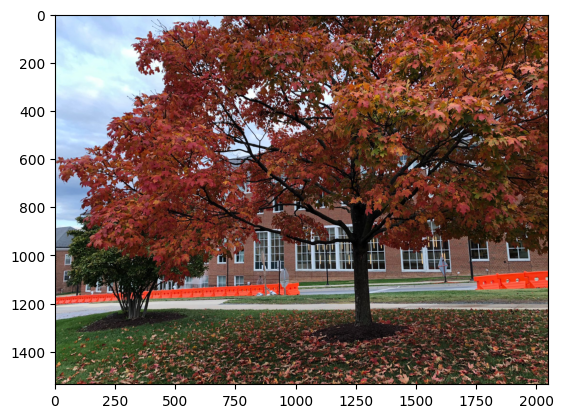

In [106]:
chirikov_decrypted_plot = plt.imshow(chirikov_decrypted)

In [196]:
im = cv2.imread('./static/images/encrypted_img.jpg')